# Equation of state (EOS) benchmarks on Fe-Ni-Cr alloy systems

This notebook provides an example workflow pipline from generating initial structures, executing high-throughput equation of state (EOS) workflow using multiples MLIPs, and analyzing the results from database.

The underlying structure generation code has been kindly shared by [Jan Jassen](https://github.com/jan-janssen) to call [structuretoolkit]() and [sqsgenerator](). If you found this example useful, please cite the following:

- Alvi, S. M. A. A., Janssen, J., Khatamsaz, D., Perez, D., Allaire, D., & Arroyave, R. (2024).
  Hierarchical Gaussian Process-Based Bayesian Optimization for Materials Discovery in High
  Entropy Alloy Spaces. *arXiv preprint arXiv:2410.04314*.
- Gehringer, D., Friák, M., & Holec, D. (2023). Models of configurationally-complex alloys made
  simple. *Computer Physics Communications, 286*, 108664.

## 1. Generate input structures

In [ ]:
from ase.build import bulk
from mlip_arena.tasks.eos_alloy.input import generate_alloy_db

In [ ]:
structure_template = bulk("Al", a=3.6, cubic=True).repeat([2, 2, 2])
elements = ["Fe", "Ni", "Cr"]
generate_alloy_db(structure_template, elements, upload=True)

## 2. Run benchmark at scale in parallel

In [1]:
from pathlib import Path

import pandas as pd
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from prefect_dask import DaskTaskRunner

from mlip_arena.models import REGISTRY
from mlip_arena.tasks.eos_alloy.flow import run_from_db

No module named 'deepmd'


In [2]:
# Orchestrate workflow runner

nodes_per_alloc = 1
gpus_per_alloc = 4
ntasks = 1

cluster_kwargs = dict(
    cores=1,
    memory="64 GB",
    shebang="#!/bin/bash",
    account="m3828",
    walltime="01:00:00",
    job_mem="0",
    job_script_prologue=[
        "source ~/.bashrc",
        "module load python",
        "source activate /pscratch/sd/c/cyrusyc/.conda/mlip-arena",
    ],
    job_directives_skip=["-n", "--cpus-per-task", "-J"],
    job_extra_directives=[
        "-J eos",
        "-q regular",
        f"-N {nodes_per_alloc}",
        "-C gpu",
        f"-G {gpus_per_alloc}",
    ],
)

cluster = SLURMCluster(**cluster_kwargs)
print(cluster.job_script())
cluster.adapt(minimum_jobs=10, maximum_jobs=30)
client = Client(cluster)

run_from_db_ = run_from_db.with_options(
    task_runner=DaskTaskRunner(address=client.scheduler.address),
    # log_prints=True,
)

# Run the workflow

results = run_from_db_(
    db_path="sqs_Fe-Ni-Cr.db", out_path="eos.h5", table_name="Fe-Ni-Cr"
)

#!/bin/bash

#SBATCH -A m3828
#SBATCH --mem=0
#SBATCH -t 01:00:00
#SBATCH -J eos
#SBATCH -q regular
#SBATCH -N 1
#SBATCH -C gpu
#SBATCH -G 4
source ~/.bashrc
module load python
source activate /pscratch/sd/c/cyrusyc/.conda/mlip-arena
/pscratch/sd/c/cyrusyc/.conda/mlip-arena/bin/python -m distributed.cli.dask_worker tcp://128.55.64.21:41405 --name dummy-name --nthreads 1 --memory-limit 59.60GiB --nanny --death-timeout 60



22:23:21.156 | INFO    | prefect.engine - Created flow run 'benign-parrot' for flow 'run-from-db'

22:23:21.160 | INFO    | prefect.engine - View at https://app.prefect.cloud/account/f7d40474-9362-4bfa-8950-ee6a43ec00f3/workspace/d4bb0913-5f5e-49f7-bfc5-06509088baeb/runs/flow-run/a449ef94-1e7d-4bf6-940c-36e829292a73

22:23:21.802 | INFO    | prefect.task_runner.dask - Connecting to existing Dask cluster SLURMCluster(28696f19, 'tcp://128.55.64.21:41405', workers=0, threads=0, memory=0 B)

22:23:43.657 | INFO    | Task run 'get_atoms_from_db-7a4' - Created task run 'get_atoms_from_db-7a4' for task 'get_atoms_from_db'

22:24:15.703 | INFO    | Task run 'get_atoms_from_db-7a4' - Finished in state Completed()

2024-12-19 22:53:36,546 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/core.py", line 175, in loads
    return msgpack.loads(
           ^^^^^^^^^^^^^^
  File "msgpack/_unpacker.pyx", line 194, in msgpack._cmsgpack.unpackb
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/core.py", line 159, in _decode_default
    return merge_and_deserialize(
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/contextlib.py", line 81, in inner
    return func(*args, **kwds)
           ^^^^^^^^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/serialize.py", line 525, in merge_and_deserialize
    return deserialize(header, merged_frames, deserializers=deserializers)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

00:17:39.232 | ERROR   | Flow run 'benign-parrot' - Encountered exception during execution: TypeError('Could not serialize object of type State\nTraceback (most recent call last):\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 60, in dumps\n    result = pickle.dumps(x, **dump_kwargs)\n             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\nTypeError: cannot pickle \'weakref.ReferenceType\' object\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 65, in dumps\n    pickler.dump(x)\nRecursionError: maximum recursion depth exceeded\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/serialize.py", line 366, in serialize\n    header, frames = dumps(x, context=context) if wants_context else dumps(x)\n                     ^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/serialize.py", line 78, in pickle_dumps\n    frames[0] = pickle.dumps(\n                ^^^^^^^^^^^^^\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 77, in dumps\n    result = cloudpickle.dumps(x, **dump_kwargs)\n             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/cloudpickle/cloudpickle.py", line 1529, in dumps\n    cp.dump(obj)\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/cloudpickle/cloudpickle.py", line 1295, in dump\n    return super().dump(obj)\n           ^^^^^^^^^^^^^^^^^\nTypeError: cannot pickle \'weakref.ReferenceType\' object\n')
Traceback (most recent call last):
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/prefect/flow_engine.py", line 652, in run_context
    yield self
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/prefect/flow_engine.py", line 696, in run_flow_sync
    engine.call_flow_fn()
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/prefect/flow_engine.py", line 675, in call_flow_fn
    result = call_with_parameters(self.flow.fn, self.parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/prefect/utilities/callables.py", line 206, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/mlip-arena/mlip_arena/tasks/eos_alloy/flow.py", line 130, in run_from_db
    return [
           ^
  File "/pscratch/sd/c/cyrusyc/mlip-arena/mlip_arena/tasks/eos_alloy/flow.py", line 131, in <listcomp>
    f.result(timeout=None, raise_on_failure=False)
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/prefect_dask/task_runners.py", line 132, in result
    future_result = self._wrapped_future.result(timeout=timeout)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/client.py", line 402, in result
    return self.client.sync(self._result, callback_timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/utils_comm.py", line 441, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/utils_comm.py", line 420, in retry
    return await coro()
           ^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-pac

00:17:39.489 | ERROR   | Flow run 'benign-parrot' - Finished in state Failed('Flow run encountered an exception: TypeError: Could not serialize object of type State\nTraceback (most recent call last):\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 60, in dumps\n    result = pickle.dumps(x, **dump_kwargs)\n             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\nTypeError: cannot pickle \'weakref.ReferenceType\' object\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 65, in dumps\n    pickler.dump(x)\nRecursionError: maximum recursion depth exceeded\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/serialize.py", line 366, in serialize\n    header, frames = dumps(x, context=context) if wants_context else dumps(x)\n                     ^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/serialize.py", line 78, in pickle_dumps\n    frames[0] = pickle.dumps(\n                ^^^^^^^^^^^^^\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 77, in dumps\n    result = cloudpickle.dumps(x, **dump_kwargs)\n             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/cloudpickle/cloudpickle.py", line 1529, in dumps\n    cp.dump(obj)\n  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/cloudpickle/cloudpickle.py", line 1295, in dump\n    return super().dump(obj)\n           ^^^^^^^^^^^^^^^^^\nTypeError: cannot pickle \'weakref.ReferenceType\' object\n')

TypeError: Could not serialize object of type State
Traceback (most recent call last):
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 60, in dumps
    result = pickle.dumps(x, **dump_kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: cannot pickle 'weakref.ReferenceType' object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 65, in dumps
    pickler.dump(x)
RecursionError: maximum recursion depth exceeded

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/serialize.py", line 366, in serialize
    header, frames = dumps(x, context=context) if wants_context else dumps(x)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/serialize.py", line 78, in pickle_dumps
    frames[0] = pickle.dumps(
                ^^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 77, in dumps
    result = cloudpickle.dumps(x, **dump_kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/cloudpickle/cloudpickle.py", line 1529, in dumps
    cp.dump(obj)
  File "/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/cloudpickle/cloudpickle.py", line 1295, in dump
    return super().dump(obj)
           ^^^^^^^^^^^^^^^^^
TypeError: cannot pickle 'weakref.ReferenceType' object


## 3. Analyze results

In [2]:
import pandas as pd 
import numpy as np
from matplotlib import colors, ticker, colormaps
from matplotlib import pyplot as plt
from ase.formula import Formula
%matplotlib inline

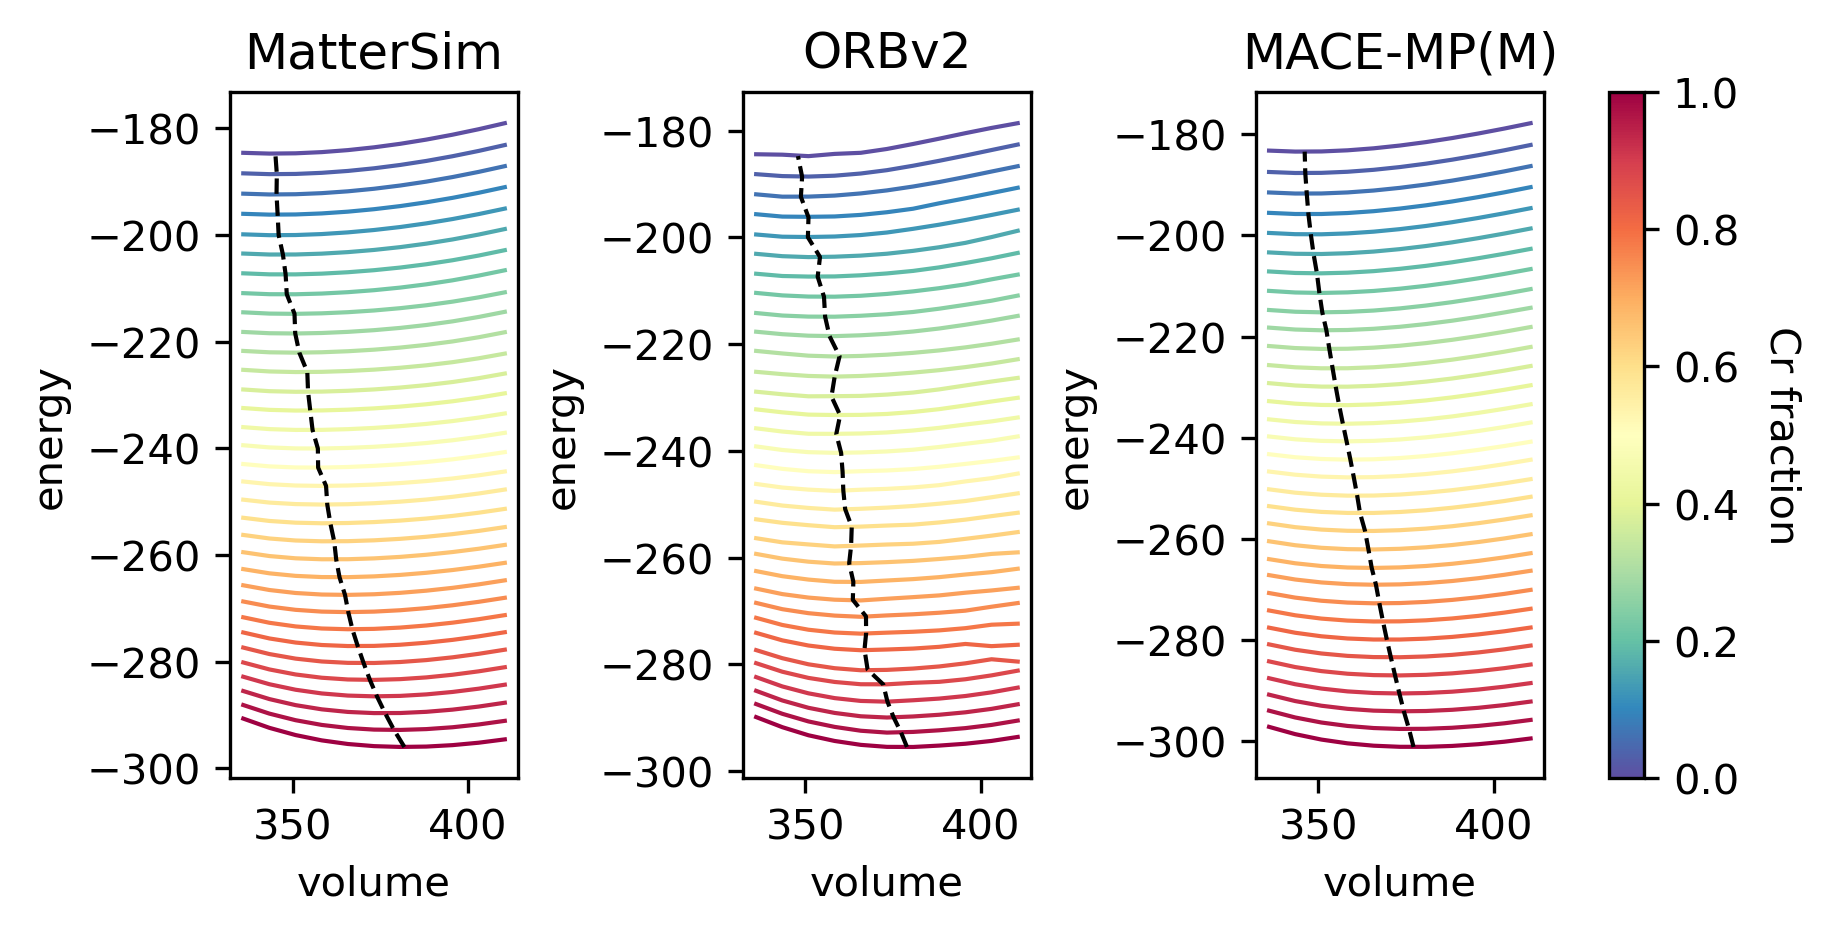

In [10]:
df = pd.read_hdf("eos.h5")

cmap = colormaps.get_cmap('Spectral').reversed()
norm = colors.Normalize(vmin=0, vmax=1)

formulae = [f for f in set(df['formula']) if 'Fe' not in f]
methods = set(df['method'])

with plt.style.context('default'):

    fig, axes = plt.subplots(
        ncols=len(methods),
        figsize=(6,3),
        layout='constrained',
        dpi=300
    )
    
    for i, method in enumerate(methods):
        ev0s = []
        for fi, formula in enumerate(formulae):
            filtered_data = df[(df['formula'] == formula) & (df['method'] == method)]
            filtered_data = filtered_data.drop_duplicates(subset=['method', 'formula', 'volume'], keep='last')
            
            ev0s.append((filtered_data['v0'].drop_duplicates()[0], filtered_data['e0'].drop_duplicates()[0]))
            c = Formula(formula) // Formula('Cr') / len(Formula(formula))
            # Plot EOS curves at different compositions
            axes[i].plot(
                filtered_data['volume'], filtered_data['energy'],
                c=cmap(norm(c)),
                lw=1
            )
            axes[i].set(
                title=method
            )

        # Plot equilibrium volume and energy line
        ev0s = np.array(sorted(ev0s, key=lambda x: x[1]))
        axes[i].plot(ev0s[:, 0], ev0s[:, 1], "--", color="black", lw=1)
        axes[i].set(
            xlabel='volume', ylabel='energy'
        )
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation='vertical', aspect=20)
    cbar.set_label("Cr fraction", rotation=270, labelpad=15)
    plt.show()

In [7]:
# Calculate compositions
elements = set().union(*[set(Formula(f)) for f in df['formula']])

data = df.assign(**{
    k: df['formula'].map(
        lambda f: Formula(f).count()[k] / sum(Formula(f).count().values()) 
        if k in Formula(f).count() else 0
    )
    for k in elements
})

data

method     formula         total_run_time          v0          e0  \
0    MatterSim    Cr11Ni21 0 days 00:00:28.339838  354.196669 -225.676697   
1    MatterSim    Cr11Ni21 0 days 00:00:28.339838  354.196669 -225.676697   
2    MatterSim    Cr11Ni21 0 days 00:00:28.339838  354.196669 -225.676697   
3    MatterSim    Cr11Ni21 0 days 00:00:28.339838  354.196669 -225.676697   
4    MatterSim    Cr11Ni21 0 days 00:00:28.339838  354.196669 -225.676697   
..         ...         ...                    ...         ...         ...   
6   MACE-MP(M)  Cr26Fe4Ni2 0 days 00:00:00.433071  369.308334 -290.555581   
7   MACE-MP(M)  Cr26Fe4Ni2 0 days 00:00:00.433071  369.308334 -290.555581   
8   MACE-MP(M)  Cr26Fe4Ni2 0 days 00:00:00.433071  369.308334 -290.555581   
9   MACE-MP(M)  Cr26Fe4Ni2 0 days 00:00:00.433071  369.308334 -290.555581   
10  MACE-MP(M)  Cr26Fe4Ni2 0 days 00:00:00.433071  369.308334 -290.555581   

          b0        b1     volume      energy       Cr       Ni     Fe  
0   0.785822 -1.069017  335.92320 -225.279831  0.34375  0.65625  0.000  
1   0.785822 -1.069017  343.38816 -225.582840  0.34375  0.65625  0.000  
2   0.785822 -1.069017  350.85312 -225.693726  0.34375  0.65625  0.000  
3   0.785822 -1.069017  358.31808 -225.655914  0.34375  0.65625  0.000  
4   0.785822 -1.069017  365.78304 -225.500259  0.34375  0.65625  0.000  
..       ...       ...        ...         ...      ...      ...    ...  
6   1.228756  5.063066  380.71296 -290.349854  0.81250  0.06250  0.125  
7   1.228756  5.063066  388.17792 -290.022858  0.81250  0.06250  0.125  
8   1.228756  5.063066  395.64288 -289.561920  0.81250  0.06250  0.125  
9   1.228756  5.063066  403.10784 -288.969910  0.81250  0.06250  0.125  
10  1.228756  5.063066  410.57280 -288.259125  0.81250  0.06250  0.125  

[117810 rows x 12 columns]

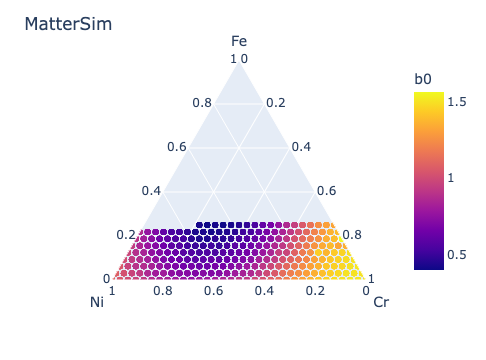

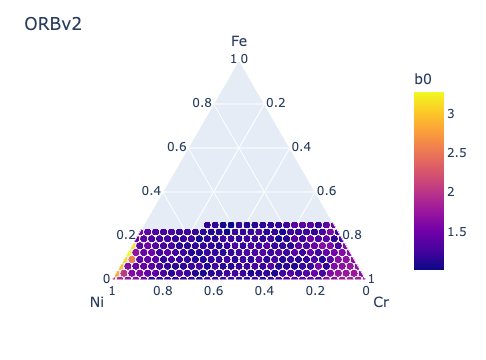

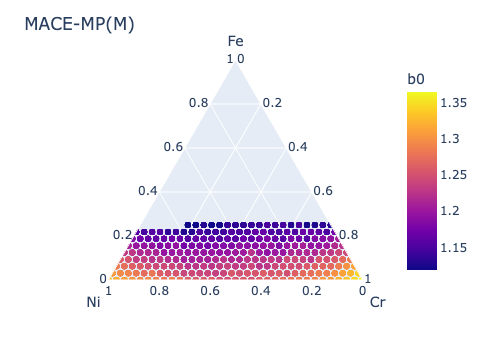

In [12]:
import plotly.express as px

for i, method in enumerate(methods):
    filtered_data = data[data['method'] == method]
    filtered_data = filtered_data.drop_duplicates(subset=['method', 'formula', 'volume'], keep='last')
    
    fig = px.scatter_ternary(
        filtered_data, a="Fe", b="Ni", c="Cr", color="b0", 
    )
    
    fig.update_layout(title=method)
    fig.show()